# Twomes interactive inverse grey-box analysis pipeline

This Jupyter Labs notebook can be used to interactively test the Twomes inverse grey-box analysis pipeline, accessing data from a Twomes database (see also [more information how to setup a Twomes server](https://github.com/energietransitie/twomes-backoffice-configuration#jupyterlab)).
Don't forget to install the requirements listed in [requirements.txt](../requirements.txt) first!



## Setting the stage

First several imports and variables need to be defined


### Imports and generic settings

In [84]:
from datetime import datetime, timedelta
import pytz
import math
import pylab as plt

import pandas as pd
import numpy as np

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')

%load_ext autoreload

%matplotlib widget
from plotter import Plot
from filewriter import ExcelWriter as ex

from extractor import WeatherExtractor, Extractor, Period

from inversegreyboxmodel import Learner

import logging
logger = logging.getLogger('Twomes data extraction')
logger.setLevel(logging.NOTSET)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Analysis settings

- which `moving_horizon_duration` should be used for the annalysis
- and various other global parameters

In [15]:
n_std_outliers = 3.0 # default for the multiplier of the the standard deviation; further out than this times the std, outliers are removed during preprocessing
up_intv = '5min' # the default upsampling interval that is used before interpolation is done
gap_n_intv = 11 # the default maximum number of consecutive NaNs to fill(one for each upsampling interval), i.e. valid measurement values (11+1)* 5 min = 1 hour apart apart will be bridget by interpolation, but not more
sampling_interval = '15min' # the default interval on which interpolation will be done during preprocessing
moving_horizon_duration_d = 7
required_columns_for_sanity = ['home_id', 'T_out_e_avg_C', 'irradiation_hor_avg_W_p_m2', 'T_in_avg_C', 'gas_sup_avg_W', 'e_remaining_heat_avg_W', 'interval_s']
sanity_fraction = 0.9

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Defining which homes, which period 

- which `homes` should be analysed
- what the location and timezone is of those homes (currently, we only support one location and timezone for a batch of homes) 
- from which `start_day` to which `end_day'  the analysis should run

In [ ]:
#location: center of Assendorp neighbourhood in Zwolle
lat, lon = 52.50655, 6.09961

#timezone: 
timezone_database = 'UTC'
timezone_homes = 'Europe/Amsterdam'

# # # Below, the maximum period for data collection
first_day = pytz.timezone(timezone_homes).localize(datetime(2021, 10, 25))
last_day = pytz.timezone(timezone_homes).localize(datetime(2022, 5, 8))

# Alternatively, you may want to test things only on a three week periode. This is a period with suitable weather and lots of homes with measurements.
# first_day = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 3))
# last_day = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 31))

# The full set of homes
homes = [803422, 805164, 809743, 811308, 815925, 817341, 822479, 829947, 830088, 831062, 839440, 845966, 845997, 846697, 857477, 864296, 873985, 879481, 881611, 886307, 895671, 897349, 899510]

# # A subset of homes
# homes = [803422, 805164, 809743]

# single home for virtual homes
# homes = [886307]


## Loading and geospatial interpolation of Dutch weather data

Using an external library installaed via [requirements.txt](../requirements.txt), load and geospatially interpolate Dutch weather data


100% 4704/4704 [01:12<00:00, 64.92it/s]


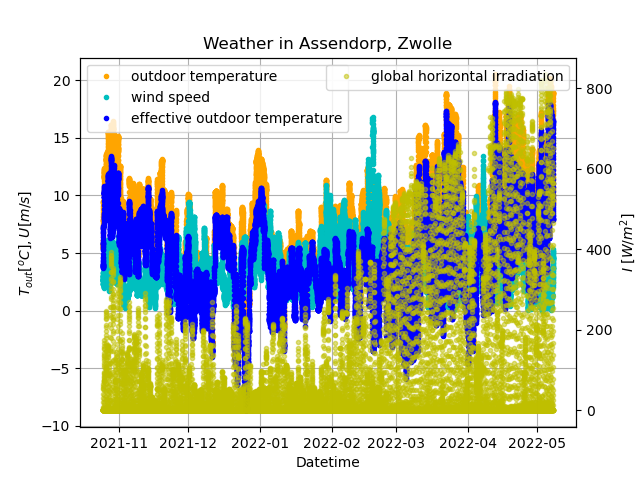

CPU times: user 1min 17s, sys: 1.44 s, total: 1min 19s
Wall time: 1min 24s


In [2]:
%%time 
%autoreload 2
# get geospatially interpolated weather from KNMI
# for Twomes, the Weather for all all homes studies can be approached by a single location
# get the dataframe only once for all homes to save time
tz_knmi='Europe/Amsterdam'

df_weather = WeatherExtractor.get_interpolated_weather_nl(first_day, last_day, lat, lon, tz_knmi, timezone_homes, sampling_interval)

### Check descriptive statisctics about the weather data

In [78]:
df_weather.describe(include='all')

,T_out_avg_C,wind_avg_m_p_s,irradiation_hor_avg_W_p_m2,T_out_e_avg_C
count,18721.000000,1.872100e+04,18721.000000,18721.000000
mean,6.754244,3.633747e+00,81.140800,4.331746
std,4.253003,2.148782e+00,157.669120,4.131663
min,-5.675577,-1.976263e-323,0.000000,-8.649752
25%,3.965954,2.094984e+00,0.000000,1.544522
50%,6.671699,3.259655e+00,0.000000,4.163721
75%,9.464444,4.775296e+00,78.900504,6.942963
max,20.504261,1.682201e+01,834.591597,18.101169


### Plot weather data

N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

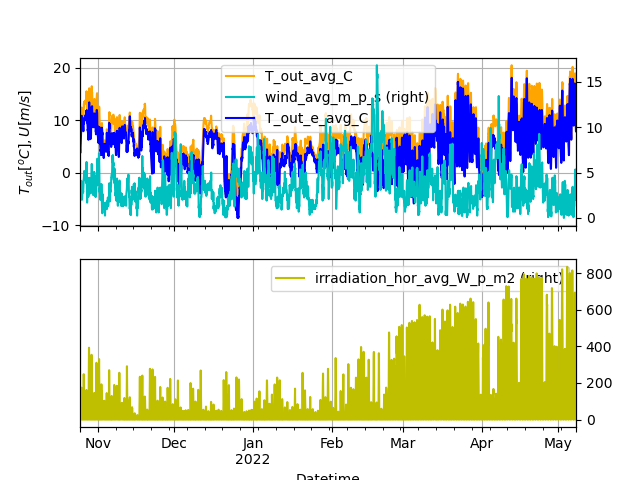

In [139]:
logger.setLevel(logging.NOTSET)
Plot.temperature_and_power_plot(df_weather,
                                temp_plot_dict = {'T_out_avg_C': 'orange', 'wind_avg_m_p_s': 'c', 'T_out_e_avg_C': 'b'},
                                temp_plot_2nd_list = ['wind_avg_m_p_s'],
                                power_plot_dict = {'irradiation_hor_avg_W_p_m2': 'y'},
                                power_plot_2nd_list = ['irradiation_hor_avg_W_p_m2']
                               )

## Getting time-interpolated home data from the Twomes database and combine with weather data

In [ ]:
%%time 


logger.setLevel(logging.INFO)

df_data_homes = Extractor.get_preprocessed_homes_data(homes, first_day, last_day, timezone_database, timezone_homes,
                                                      up_intv, gap_n_intv, sampling_interval, 
                                                      required_columns_for_sanity,
                                                      df_weather)
filename_prefix = datetime.now().astimezone(pytz.timezone('Europe/Amsterdam')).replace(microsecond=0).isoformat().replace(":","")
# ex.write(df_data_homes, str('{0}-data_homes-{1}-{2}.xlsx'.format(filename_prefix, first_day.isoformat(),last_day.isoformat())))
Extractor.write_home_data_to_csv(df_data_homes, str('{0}-data_homes-{1}-{2}.csv'.format(filename_prefix, first_day.isoformat(),last_day.isoformat())))

logger.setLevel(logging.NOTSET)


### Optional block to get interpolated data from virtual homes in CSV files and combine with weather data already obtained


In [5]:
# %%time 
# %autoreload 2
# logger.setLevel(logging.INFO)

# homes = [
#     60200, 
#     120100, 
#     150080, 
#     150100, 
#     200060, 
#     300040, 
#     400030, 
#     600020 
# ]

# # For virtual homes, only the following period is valid:
# first_day = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 3))
# last_day = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 24))

# df_data_homes = pd.DataFrame()
# for home_id in homes:
#     df_data_homes = pd.concat([df_data_homes, Extractor.get_virtual_home_data_csv(str('../data/virtualhome_P{0}.csv'.format(home_id)), timezone_homes)], axis=0)

# logger.setLevel(logging.NOTSET)


In [87]:
df_data_homes

T_out_avg_C  wind_avg_m_p_s  \
home_id  timestamp                                                
803422.0 2021-10-25 00:00:00+02:00     6.104595        2.344984   
         2021-10-25 00:15:00+02:00     5.949466        2.344984   
         2021-10-25 00:30:00+02:00     5.794336        2.344984   
         2021-10-25 00:45:00+02:00     5.639207        2.344984   
         2021-10-25 01:00:00+02:00     5.484077        2.344984   
...                                         ...             ...   
NaN      2022-05-08 22:45:00+02:00          NaN             NaN   
         2022-05-08 23:00:00+02:00          NaN             NaN   
         2022-05-08 23:15:00+02:00          NaN             NaN   
         2022-05-08 23:30:00+02:00          NaN             NaN   
         2022-05-08 23:45:00+02:00          NaN             NaN   

                                    irradiation_hor_avg_W_p_m2  T_out_e_avg_C  \
home_id  timestamp                                                              
803422.0 2021-10-25 00:00:00+02:00                         0.0       4.541273   
         2021-10-25 00:15:00+02:00                         0.0       4.386143   
         2021-10-25 00:30:00+02:00                         0.0       4.231014   
         2021-10-25 00:45:00+02:00                         0.0       4.075884   
         2021-10-25 01:00:00+02:00                         0.0       3.920755   
...                                                        ...            ...   
NaN      2022-05-08 22:45:00+02:00                         NaN            NaN   
         2022-05-08 23:00:00+02:00                         NaN            NaN   
         2022-05-08 23:15:00+02:00                         NaN            NaN   
         2022-05-08 23:30:00+02:00                         NaN            NaN   
         2022-05-08 23:45:00+02:00                         NaN            NaN   

                                    T_in_avg_C  T_set_first_C  interval_s  \
home_id  timestamp                                                          
803422.0 2021-10-25 00:00:00+02:00         NaN            NaN       900.0   
         2021-10-25 00:15:00+02:00         NaN            NaN       900.0   
         2021-10-25 00:30:00+02:00         NaN            NaN       900.0   
         2021-10-25 00:45:00+02:00         NaN            NaN       900.0   
         2021-10-25 01:00:00+02:00         NaN            NaN       900.0   
...                                        ...            ...         ...   
NaN      2022-05-08 22:45:00+02:00         NaN            NaN       900.0   
         2022-05-08 23:00:00+02:00         NaN            NaN       900.0   
         2022-05-08 23:15:00+02:00         NaN            NaN       900.0   
         2022-05-08 23:30:00+02:00         NaN            NaN       900.0   
         2022-05-08 23:45:00+02:00         NaN            NaN       900.0   

                                    gas_sup_avg_W  e_used_avg_W  \
home_id  timestamp                                                
803422.0 2021-10-25 00:00:00+02:00            NaN           NaN   
         2021-10-25 00:15:00+02:00            NaN           NaN   
         2021-10-25 00:30:00+02:00            NaN           NaN   
         2021-10-25 00:45:00+02:00            NaN           NaN   
         2021-10-25 01:00:00+02:00            NaN           NaN   
...                                           ...           ...   
NaN      2022-05-08 22:45:00+02:00    5275.500000         196.0   
         2022-05-08 23:00:00+02:00       0.000000         164.0   
         2022-05-08 23:15:00+02:00       0.000000         236.0   
         2022-05-08 23:30:00+02:00       0.000000         192.0   
         2022-05-08 23:45:00+02:00      39.077778         164.0   

                                    e_returned_avg_W  e_remaining_heat_avg_W  \
home_id  timestamp                                                             
803422.0 2021-10-25 00:00:00+02:00               NaN                     NaN

### Present sanity metrics for the extracted data

In [7]:
total_measurement_time = timedelta(seconds = int(df_data_homes['interval_s'].sum()))
print('Total measurement time: ', total_measurement_time)
sane_fraction = df_data_homes['sanity_frac'].mean()
print('Sane fraction measurement time: {:.2f}'.format(sane_fraction))
sane_measurement_time = total_measurement_time * sane_fraction
print('Sane  measurement time: ', sane_measurement_time)

#see more statisctics
df_data_homes.describe(include='all')

Total measurement time:  4487 days, 0:00:00
Sane fraction measurement time: 0.37
Sane  measurement time:  1639 days, 3:19:55.671038


,T_out_avg_C,wind_avg_m_p_s,irradiation_hor_avg_W_p_m2,T_out_e_avg_C,T_in_avg_C,T_set_first_C,interval_s,gas_sup_avg_W,e_used_avg_W,e_returned_avg_W,e_remaining_heat_avg_W,sanity_frac
count,430583.000000,4.305830e+05,430583.000000,430583.000000,163391.000000,83996.000000,430752.0,190682.000000,190732.000000,190732.000000,190732.000000,430773.000000
mean,6.754244,3.633747e+00,81.140800,4.331746,18.552935,13.217308,900.0,1720.781970,258.305463,72.118889,186.186574,0.365308
std,4.252894,2.148727e+00,157.665092,4.131557,1.590409,7.312317,0.0,2711.371862,396.506099,293.373249,525.731112,0.481517
min,-5.675577,-1.976263e-323,0.000000,-8.649752,11.938529,0.000000,900.0,0.000000,0.000000,0.000000,-4056.000000,0.000000
25%,3.965954,2.094984e+00,0.000000,1.544522,17.533333,5.998333,900.0,0.000000,60.000000,0.000000,56.000000,0.000000
50%,6.671699,3.259655e+00,0.000000,4.163721,18.666667,17.000000,900.0,117.233333,132.000000,0.000000,128.000000,0.000000
75%,9.464444,4.775296e+00,78.900504,6.942963,19.873333,18.500000,900.0,2696.366667,276.000000,0.000000,272.000000,1.000000
max,20.504261,1.682201e+01,834.591597,18.101169,28.650000,44.000000,900.0,24306.377778,5692.000000,4088.000000,5692.000000,1.000000


### Optional block to write the extracted data to a CSV file

N.B. In a future version we consider using the Apache Parquet format.

In [8]:
# %%time 
# from tqdm import tqdm_notebook

# %autoreload 2
# filename_prefix = datetime.now().astimezone(pytz.timezone('Europe/Amsterdam')).replace(microsecond=0).isoformat().replace(":","")

# first_day = pytz.timezone(timezone_homes).localize(datetime(2021, 10, 25))
# last_day = pytz.timezone(timezone_homes).localize(datetime(2022, 5, 8))

# df_rawdata = pd.DataFrame()
# home_iterator = tqdm_notebook(homes)

# for home_id in home_iterator:
#     # print('Processing ', home_id)
#     extractor = Extractor(home_id, Period(first_day, last_day))
#     df_rawdata = extractor.get_rawdata()
#     df_rawdata.describe(include='all')
#     Extractor.write_raw_data_to_csv(df_rawdata, str('{0}-rawdata_P{1}-{2}-{3}.csv'.format(filename_prefix, home_id, first_day.isoformat(),last_day.isoformat())))



## Learn parameters using inverse grey-box analysis

Most of the heavy lifting is done by the `learn_home_parameter_moving_horizon()` function, which again uses the [GEKKO Python](https://machinelearning.byu.edu/) dynamic optimization toolkit.

In [16]:
%%time 
%autoreload 2


sanity_fraction_analysis = sanity_fraction

# Use one of the lines below to set the moving horizon duration used for analysis 
# moving_horizon_duration_d_analysis = 14
moving_horizon_duration_d_analysis = moving_horizon_duration_d


# learn the model parameters and write rerults an intermediate results to excel files
df_results = Learner.learn_home_parameter_moving_horizon(df_data_homes, 
                                                         n_std_outliers, up_intv, gap_n_intv, sampling_interval, 
                                                         moving_horizon_duration_d_analysis, sanity_fraction_analysis,
                                                         hint_A_m2=None, ev_type=2)



Homes to analyse:  Float64Index([803422.0, 805164.0, 809743.0, 811308.0, 815925.0, 817341.0,
              822479.0, 829947.0, 830088.0, 831062.0, 839440.0, 845966.0,
              845997.0, 846697.0, 857477.0, 864296.0, 873985.0, 879481.0,
              881611.0, 886307.0, 895671.0, 897349.0, 899510.0],
             dtype='float64', name='home_id')
Start of analyses:  2021-10-25 00:00:00+02:00
End of analyses:  2022-05-08 23:45:00+02:00
Moving horizon:  7D
#standard deviations for outlier removal:  3.0
Upsampling_interval:  5min
#upsampling intervals bridged during interpolation (max):  11
Interpolation interval:  15min
Hint for effective window are A [m^2]:  None
Hint for superior heating efficiency eta [-]:  0.97
EV_TYPE:  2


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 803422.0 in period from 2022-02-14 00:00:00+01:00 to 2022-02-20 23:45:00+01:00; skipping...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 809743.0 in period from 2022-03-21 00:00:00+01:00 to 2022-03-28 00:45:00+02:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 809743.0 in period from 2022-04-11 00:00:00+02:00 to 2022-04-17 23:45:00+02:00; skipping...


  0%|          | 0/28 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 811308.0 in period from 2021-12-20 00:00:00+01:00 to 2021-12-26 23:45:00+01:00; skipping...


  0%|          | 0/28 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 815925.0 in period from 2022-01-24 00:00:00+01:00 to 2022-01-30 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 815925.0 in period from 2022-02-28 00:00:00+01:00 to 2022-03-06 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 815925.0 in period from 2022-04-18 00:00:00+02:00 to 2022-04-24 23:45:00+02:00; skipping...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 822479.0 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 830088.0 in period from 2022-01-31 00:00:00+01:00 to 2022-02-06 23:45:00+01:00; skipping...


  0%|          | 0/28 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 831062.0 in period from 2022-03-14 00:00:00+01:00 to 2022-03-20 23:45:00+01:00; skipping...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 846697.0 in period from 2022-01-31 00:00:00+01:00 to 2022-02-06 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 846697.0 in period from 2022-03-07 00:00:00+01:00 to 2022-03-13 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 846697.0 in period from 2022-04-04 00:00:00+02:00 to 2022-04-10 23:45:00+02:00; skipping...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 864296.0 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 899510.0 in period from 2022-02-28 00:00:00+01:00 to 2022-03-06 23:45:00+01:00; skipping...


DONE: Analysis of all homes complete; writing files.
          T_out_avg_C  wind_avg_m_p_s  irradiation_hor_avg_W_p_m2  \
count   143808.000000   143808.000000               143808.000000   
unique            NaN             NaN                         NaN   
top               NaN             NaN                         NaN   
freq              NaN             NaN                         NaN   
mean         5.804071        4.411796                   67.815297   
std          3.636346        2.465866                  132.186941   
min         -5.675577        0.085329                    0.000000   
25%          3.647411        2.594067                    0.000000   
50%          5.849563        4.104638                    0.000000   
75%          8.113662        5.775296                   61.876418   
max         20.504261       16.822007                  798.697414   

        T_out_e_avg_C     T_in_avg_C  T_set_first_C  interval_s  \
count   143808.000000  141345.000000   60220.000000

## Show the results

#### Show all data, with the best plot 

In [11]:
df_results

T_out_avg_C  wind_avg_m_p_s  \
home_id  timestamp                                                
803422.0 2022-01-17 00:00:00+01:00     6.199633        4.000000   
         2022-01-17 00:15:00+01:00     6.221626        4.000000   
         2022-01-17 00:30:00+01:00     6.243619        4.000000   
         2022-01-17 00:45:00+01:00     6.265612        4.000000   
         2022-01-17 01:00:00+01:00     6.287605        4.000000   
...                                         ...             ...   
899510.0 2022-03-27 23:45:00+02:00     4.868792        1.731715   
         2022-03-28 00:00:00+02:00     4.622470        1.775296   
         2022-03-28 00:15:00+02:00     4.447268        1.840210   
         2022-03-28 00:30:00+02:00     4.272066        1.905124   
         2022-03-28 00:45:00+02:00     4.096863        1.970037   

                                    irradiation_hor_avg_W_p_m2  T_out_e_avg_C  \
home_id  timestamp                                                              
803422.0 2022-01-17 00:00:00+01:00                         0.0       3.532967   
         2022-01-17 00:15:00+01:00                         0.0       3.554960   
         2022-01-17 00:30:00+01:00                         0.0       3.576953   
         2022-01-17 00:45:00+01:00                         0.0       3.598946   
         2022-01-17 01:00:00+01:00                         0.0       3.620939   
...                                                        ...            ...   
899510.0 2022-03-27 23:45:00+02:00                         0.0       3.714315   
         2022-03-28 00:00:00+02:00                         0.0       3.438940   
         2022-03-28 00:15:00+02:00                         0.0       3.220461   
         2022-03-28 00:30:00+02:00                         0.0       3.001983   
         2022-03-28 00:45:00+02:00                         0.0       2.783505   

                                    T_in_avg_C  T_set_first_C  interval_s  \
home_id  timestamp                                                          
803422.0 2022-01-17 00:00:00+01:00   19.883333            NaN       900.0   
         2022-01-17 00:15:00+01:00   19.753333            NaN       900.0   
         2022-01-17 00:30:00+01:00   19.570000            NaN       900.0   
         2022-01-17 00:45:00+01:00   19.446667            NaN       900.0   
         2022-01-17 01:00:00+01:00   19.310000            NaN       900.0   
...                                        ...            ...         ...   
899510.0 2022-03-27 23:45:00+02:00         NaN            NaN       900.0   
         2022-03-28 00:00:00+02:00         NaN            NaN       900.0   
         2022-03-28 00:15:00+02:00         NaN            NaN       900.0   
         2022-03-28 00:30:00+02:00         NaN            NaN       900.0   
         2022-03-28 00:45:00+02:00         NaN            NaN       900.0   

                                    gas_sup_avg_W  e_used_avg_W  \
home_id  timestamp                                                
803422.0 2022-01-17 00:00:00+01:00       0.000000         156.0   
         2022-01-17 00:15:00+01:00       0.000000         136.0   
         2022-01-17 00:30:00+01:00       0.000000         128.0   
         2022-01-17 00:45:00+01:00       0.000000         140.0   
         2022-01-17 01:00:00+01:00       0.000000         152.0   
...                                           ...           ...   
899510.0 2022-03-27 23:45:00+02:00       0.000000        1460.0   
         2022-03-28 00:00:00+02:00       0.000000         244.0   
         2022-03-28 00:15:00+02:00       0.000000         168.0   
         2022-03-28 00:30:00+02:00      39.077778         160.0   
         2022-03-28 00:45:00+02:00       0.000000         224.0   

                                    e_returned_avg_W  e_remaining_heat_avg_W  \
home_id  timestamp                                                             
803422.0 2022-01-17 00:00:00+01:00               0.0                   156.0

#### Show a plot with the best fitting simulated temperature

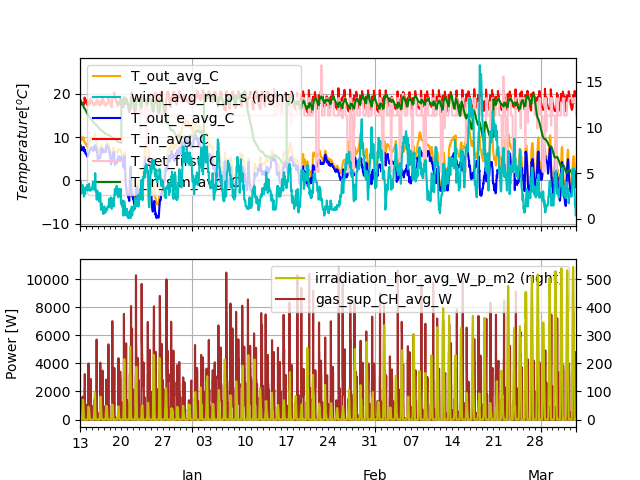

In [142]:
%autoreload 2
Plot.temperature_and_power_plot(df_results.loc[817341],
                                temp_plot_dict = {'T_out_avg_C': 'orange', 'wind_avg_m_p_s': 'c', 'T_out_e_avg_C': 'b', 'T_in_avg_C': 'red', 'T_set_first_C': 'pink', 'T_in_sim_avg_C': 'green'},
                                temp_plot_2nd_list = ['wind_avg_m_p_s'],
                                power_plot_dict = {'irradiation_hor_avg_W_p_m2': 'y', 'gas_sup_CH_avg_W': 'brown'},
                                power_plot_2nd_list = ['irradiation_hor_avg_W_p_m2']
                               )

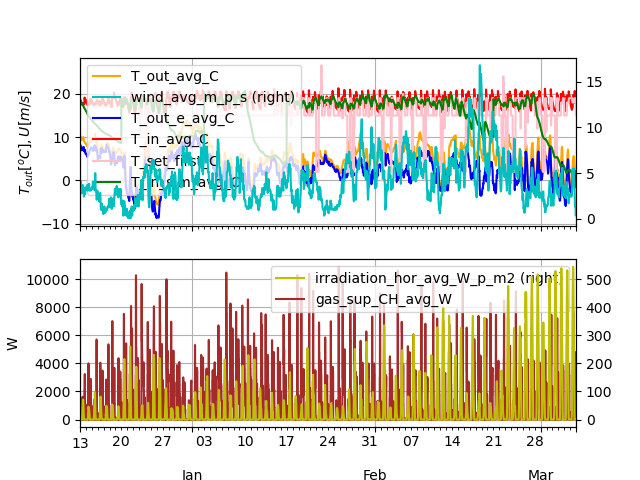

In [118]:
#define subplot layout
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
temp_plot_dict = {'T_out_avg_C': 'orange', 'wind_avg_m_p_s': 'c', 'T_out_e_avg_C': 'b', 'T_in_avg_C': 'red', 'T_set_first_C': 'pink', 'T_in_sim_avg_C': 'green'}
temp_plot_2nd_list = ['wind_avg_m_p_s']
power_plot_dict = {'irradiation_hor_avg_W_p_m2': 'y', 'gas_sup_CH_avg_W': 'brown'}
power_plot_2nd_list = ['irradiation_hor_avg_W_p_m2']

#add DataFrames to subplots
df[temp_plot_dict.keys()].plot(
    ax=axes[0],
    secondary_y=temp_plot_2nd_list, 
    grid=True, 
    legend=True, 
    color=temp_plot_dict,
    xlabel='Datetime',
    ylabel = r'$T_{out} [^oC], U [m/s]$'
)

df[power_plot_dict.keys()].plot(
    ax=axes[1],
    secondary_y=power_plot_2nd_list, 
    mark_right=True, 
    grid=True, 
    legend=True, 
    color=power_plot_dict,
    xlabel='Datetime',
    ylabel = r'W'
)

plt.show()

In [13]:
#plot a series of weeks for all homes
# plt.ioff()

# for home_id in homes_to_analyze:
#     df_data_one_home = df_data_homes.loc[home_id]
#     for moving_horizon_start in pd.date_range(start=first_day, end=first_day, inclusive='left', freq='7D'):
#         moving_horizon_end = min(first_day, moving_horizon_start + timedelta(days=7))
#         df_moving_horizon = df_data_one_home[moving_horizon_start:moving_horizon_end]
#         Plot.weather_and_other_temperatures(home_id, df_moving_horizon, ['indoor_temp_degC'])

# plt.ion()  
    

In [12]:
# plot temperature data of multiple homes from an array 
# # %autoreload 2
# for home_id in homes_to_analyze:
#     df_data_one_home = df_data_homes.loc[home_id]
#     Plot.weather_and_other_temperatures(home_id, df_data_one_home, [('T_in_avg_C','r'),('T_set_first_C','g')])

# # N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks
